# ST7 Planification quotidienne d’une équipe mobile
# Phase II

## Importation de modules

In [1]:
# module importation
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from gurobipy import *
%matplotlib inline

# utilities
from utils import plot_map, store_result, plot_agenda

# model classes for employees and nodes
from models_v2 import Employee, Node, Task, Home, Unavail

## Quelques démos et tests de notre implémentation

### Liste des répertoires

In [2]:
path_australia = "./data/InstancesV2/InstanceAustraliaV2.xlsx"
path_austria = "./data/InstancesV2/InstanceAustriaV2.xlsx"
path_bordeaux = "./data/InstancesV2/InstanceBordeauxV2.xlsx"
path_poland = "./data/InstancesV2/InstancePolandV2.xlsx"
path_spain = "./data/InstancesV2/InstanceSpainV2.xlsx"
path_easy = "./data/InstancesV2/InstanceEasyV2.xlsx"

path_result_australia = "./results/SolutionAustraliaV2.txt"
path_result_austria = "./results/SolutionAustriaV2.txt"
path_result_bordeaux = "./results/SolutionBordeauxV2.txt"
path_result_poland = "./results/SolutionPolandV2.txt"
path_result_spain = "./results/SolutionSpainV2.txt"
path_result_easy = "./results/SolutionEasyV2.txt"

In [3]:
path_to_test = path_bordeaux
path_result = path_result_bordeaux

### Test
La fonction suivante charge les données à partir du fichier Excel

In [4]:
def load_data_from_path(path_to_instance: str):
    # load employee data
    Employee.load_excel(path_to_instance)

    # load node data
    Node.clear_previous_data()
    for cls in [Home, Task, Unavail]:
        cls.load_excel(path_to_instance)
    Node.initialize_distance() # distance matrix calculation

Chargement des données

In [5]:
load_data_from_path(path_to_test)

#### Vérifications des cardinaux des nœuds et des employés

In [6]:
assert Home.count == Employee.count # each employee should have exactly one home and one lunch
assert Node.count == (Home.count + Task.count + Unavail.count)

#### Les cardinaux des classes et les indices des nœuds et des employés

In [7]:
# constants
W = Task.count
U = Unavail.count
T = Employee.count
V = Node.count

# indices of employees, homes, lunches, tasks, unavailabilities
employees = list(range(T))
homes = list(range(T))
tasks = list(range(T, T + W))
unavails = list((range(T + W, V)))

nodes = homes + tasks + unavails

### Test de l’implémentation de la fonction de représentation \_\_repr\_\_

In [8]:
print("Closed intervals of task T2 in minutes:")
Task.list[1].closed_intervals

Closed intervals of task T2 in minutes:


[(480, 540)]

In [9]:
print("Unavailabilities of employee at index 1:")
Employee.list[0].unavails

Unavailabilities of employee at index 1:


[Unavailability(Valentin, start=03:00PM, end=06:00PM)]

### Tests des fonctions d’affichage

In [10]:
print("First two employees:")
for index in employees[:2]:
    print(Employee.list[index])

print("\nFirst two homes:")
for index in homes[:2]:
    print(Node.list[index])

print("\nFirst two tasks:")
for index in tasks[:2]:
    print(Node.list[index])

print("\nFirst two unavailabilities:")
for index in unavails[:2]:
    print(Node.list[index].employee)

First two employees:
Valentin
Ambre

First two homes:
Home(Valentin)
Home(Ambre)

First two tasks:
Task(id=T1, position=[-0.3193922422375719, 44.55654938342008], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] 
Task(id=T2, position=[-0.6086852638150881, 44.96750095217799], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] 

First two unavailabilities:
Valentin


#### La matrice des distances des cinq premiers nœuds de l’instance que nous testons

In [11]:
# the distance between a node to itself should be 0
assert Node.distance[0,0] == Node.distance[1,1] == Node.distance[2,2] == 0

# the distance matrix should be symmetrical
assert Node.distance[2,3] == Node.distance[3,2]
assert Node.distance[5, 1] == Node.distance[1, 5]

# print the sub-matrix of the 5 first elements of the distance matrix
Node.distance[:5, :5]

array([[    0.        , 23906.83058516, 77088.14164263, 26425.09673473,
         6932.25850055],
       [23906.83058516,     0.        , 58439.72228403, 17830.47320533,
        24334.2333104 ],
       [77088.14164263, 58439.72228403,     0.        , 51085.9624923 ,
        73072.41327132],
       [26425.09673473, 17830.47320533, 51085.9624923 ,     0.        ,
        21986.45628832],
       [ 6932.25850055, 24334.2333104 , 73072.41327132, 21986.45628832,
            0.        ]])

La fonction suivante lit les données d’une tâche et retourne une liste de tuples représentants les intervalles d’ouverture de la tâche

In [12]:
def open_intervals(i):
    d, f = Node.list[i].opening_time, Node.list[i].closing_time
    task_duration = Node.list[i].duration
    l = [d]
    for s, e in Node.list[i].closed_intervals:
        l.append(s)
        l.append(e)
    l.append(f)
    return [(l[j],l[j+1]) for j in range(0,len(l),2) if l[j+1] - l[j] >= task_duration]

In [13]:
open_intervals(tasks[3])

[(480, 1080)]

#### Variables et Contraintes

In [14]:
m = Model("DB")

# an arbitrarily big variable
M = 1000000

# decision variables
X = {(i, j) : m.addVar(vtype = GRB.BINARY, name = f'x{i}_{j}') for i in nodes for j in nodes if i != j}
Y = {(k, i) : m.addVar(vtype = GRB.BINARY, name = f'y{k}_{i}') for k in employees for i in nodes}
B = {i : m.addVar(vtype = GRB.INTEGER, name = f'b{i}', lb = 0) for i in nodes}
L = {(k, i) : m.addVar(vtype = GRB.BINARY) for k in employees for i in nodes}

# constraints

# C1
for i in nodes:
    m.addConstr(quicksum([X[(i,j)] for j in nodes if i != j]) == quicksum([X[(j,i)] for j in nodes if i != j]))

# C2
for j in homes + tasks:
    m.addConstr(quicksum([X[(i,j)] for i in nodes if i != j]) <= 1)

# C3_a
for j in unavails:
    m.addConstr(quicksum([X[(i,j)] for i in nodes if i != j]) == 1)

# C3_b
for i in homes + unavails:
    employee = Node.list[i].employee
    for k in employees:
        if employee == Employee.list[k] :
            m.addConstr(Y[(k,i)] == 1)
        else:
            m.addConstr(Y[(k,i)] == 0)
          
# C4
for i in nodes:
    for j in nodes:
        if i != j:
            for k in employees:
                m.addConstr(Y[(k,i)] <= Y[(k,j)] + 1-X[(i,j)])
                m.addConstr(Y[(k,i)] >= Y[(k,j)] - 1+X[(i,j)])

# C5
for i in tasks:
    m.addConstr(B[i] >= Node.list[i].opening_time)
    m.addConstr(Node.list[i].duration + B[i] <= Node.list[i].closing_time)
    
# C6_a
for k in employees:
    m.addConstr(B[k] >= Employee.list[k].start_time)

# C6_b
for i in unavails:
    m.addConstr(B[i] == Node.list[i].opening_time)

# C7
for i in tasks:
    intervals = open_intervals(i)
    
    t = {l : m.addVar(vtype = GRB.BINARY, name = f't{l}') for l in range(len(intervals))}
    m.addConstr(quicksum([t[l] for l in range(len(intervals))]) == quicksum([X[(i,j)] for j in nodes if i != j]))
    
    for l in range(len(intervals)):
        start, end = intervals[l]
        m.addConstr(B[i] >= start - (1-t[l])*M)
        m.addConstr(B[i] + Node.list[i].duration <= end + (1-t[l])*M)

# C8
for k in employees:
    for i in tasks:
        m.addConstr(B[k] + ceil(Node.distance[k,i]/Employee.speed) + L[(k,k)]*60 - (1 - X[(k,i)]) * M <= B[i]) 

# C9
for k in employees:
    for i in tasks:
        m.addConstr(B[i] + Node.list[i].duration + ceil(Node.distance[i,k]/Employee.speed) + L[(k,i)]*60 <= Employee.list[k].end_time + M*(1 - X[(i,k)])) 

# C10_a
for k in employees:
    m.addConstr(quicksum([L[(k,i)] for i in nodes]) == 1)

# C10_b
for k in employees:
    for i in nodes:
        m.addConstr(Y[(k,i)] >= L[(k,i)])

# C10_c 
for i in nodes:
    for k in employees:
        duree_i = 0 if i in homes else Node.list[i].duration
        m.addConstr(B[i] + duree_i + 60*L[(k,i)] <= 60*14 + (1-L[(k,i)])*M)
        m.addConstr(B[i] + duree_i >= 60*12 - (1-L[(k,i)])*M)

# C11
for i in tasks + unavails:
    m.addConstr(quicksum([Y[(k,i)] for k in employees]) <= quicksum([X[(j,i)] for j in nodes if j != i]))

# C12
for i in tasks + unavails:
    for j in tasks + unavails:
        if i != j:
            m.addConstr(B[i] + Node.list[i].duration + ceil(Node.distance[i,j]/Employee.speed) + quicksum([L[(k,i)] for k in employees])*60 <= B[j] + M * (1-X[(i,j)]) ) 

# C13
for k in employees:
    for i in tasks:
        m.addConstr(Employee.list[k].level >= Node.list[i].level - M * (1 - Y[(k,i)]))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-27


In [15]:
# On maximise la durée totale des tâches effectuées
obj = quicksum([X[(i,j)]*Node.list[j].duration for i in nodes for j in tasks if i != j])

m.setObjective(obj, GRB.MAXIMIZE)

In [16]:
'''
if not os.path.isdir(path_result):
    store_result(target_path = path_result,
                 employees = Employee.list,
                 tasks=Task.list[2*T:2*T+W+U], z=Z, b=B)
'''

'\nif not os.path.isdir(path_result):\n    store_result(target_path = path_result,\n                 employees = Employee.list,\n                 tasks=Task.list[2*T:2*T+W+U], z=Z, b=B)\n'

### On procède selon la méthode epsilon-constraints pour trouver les solutions de l'optimisation bi-critères

Itération 1 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 7
1 -> 11
3 -> 1
4 -> 10
5 -> 8
6 -> 4
7 -> 6
8 -> 3
9 -> 5
10 -> 12
11 -> 9
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 480.0
B[3] = 998.0
B[4] = 660.0
B[5] = 720.0
B[6] = 572.0
B[7] = 490.0
B[8] = 871.0
B[9] = 627.0
B[10] = 818.0
B[11] = 559.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 4 au temps 720.0 
Le technicien 1 effectue sa pause au noeud 5 au temps 780.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


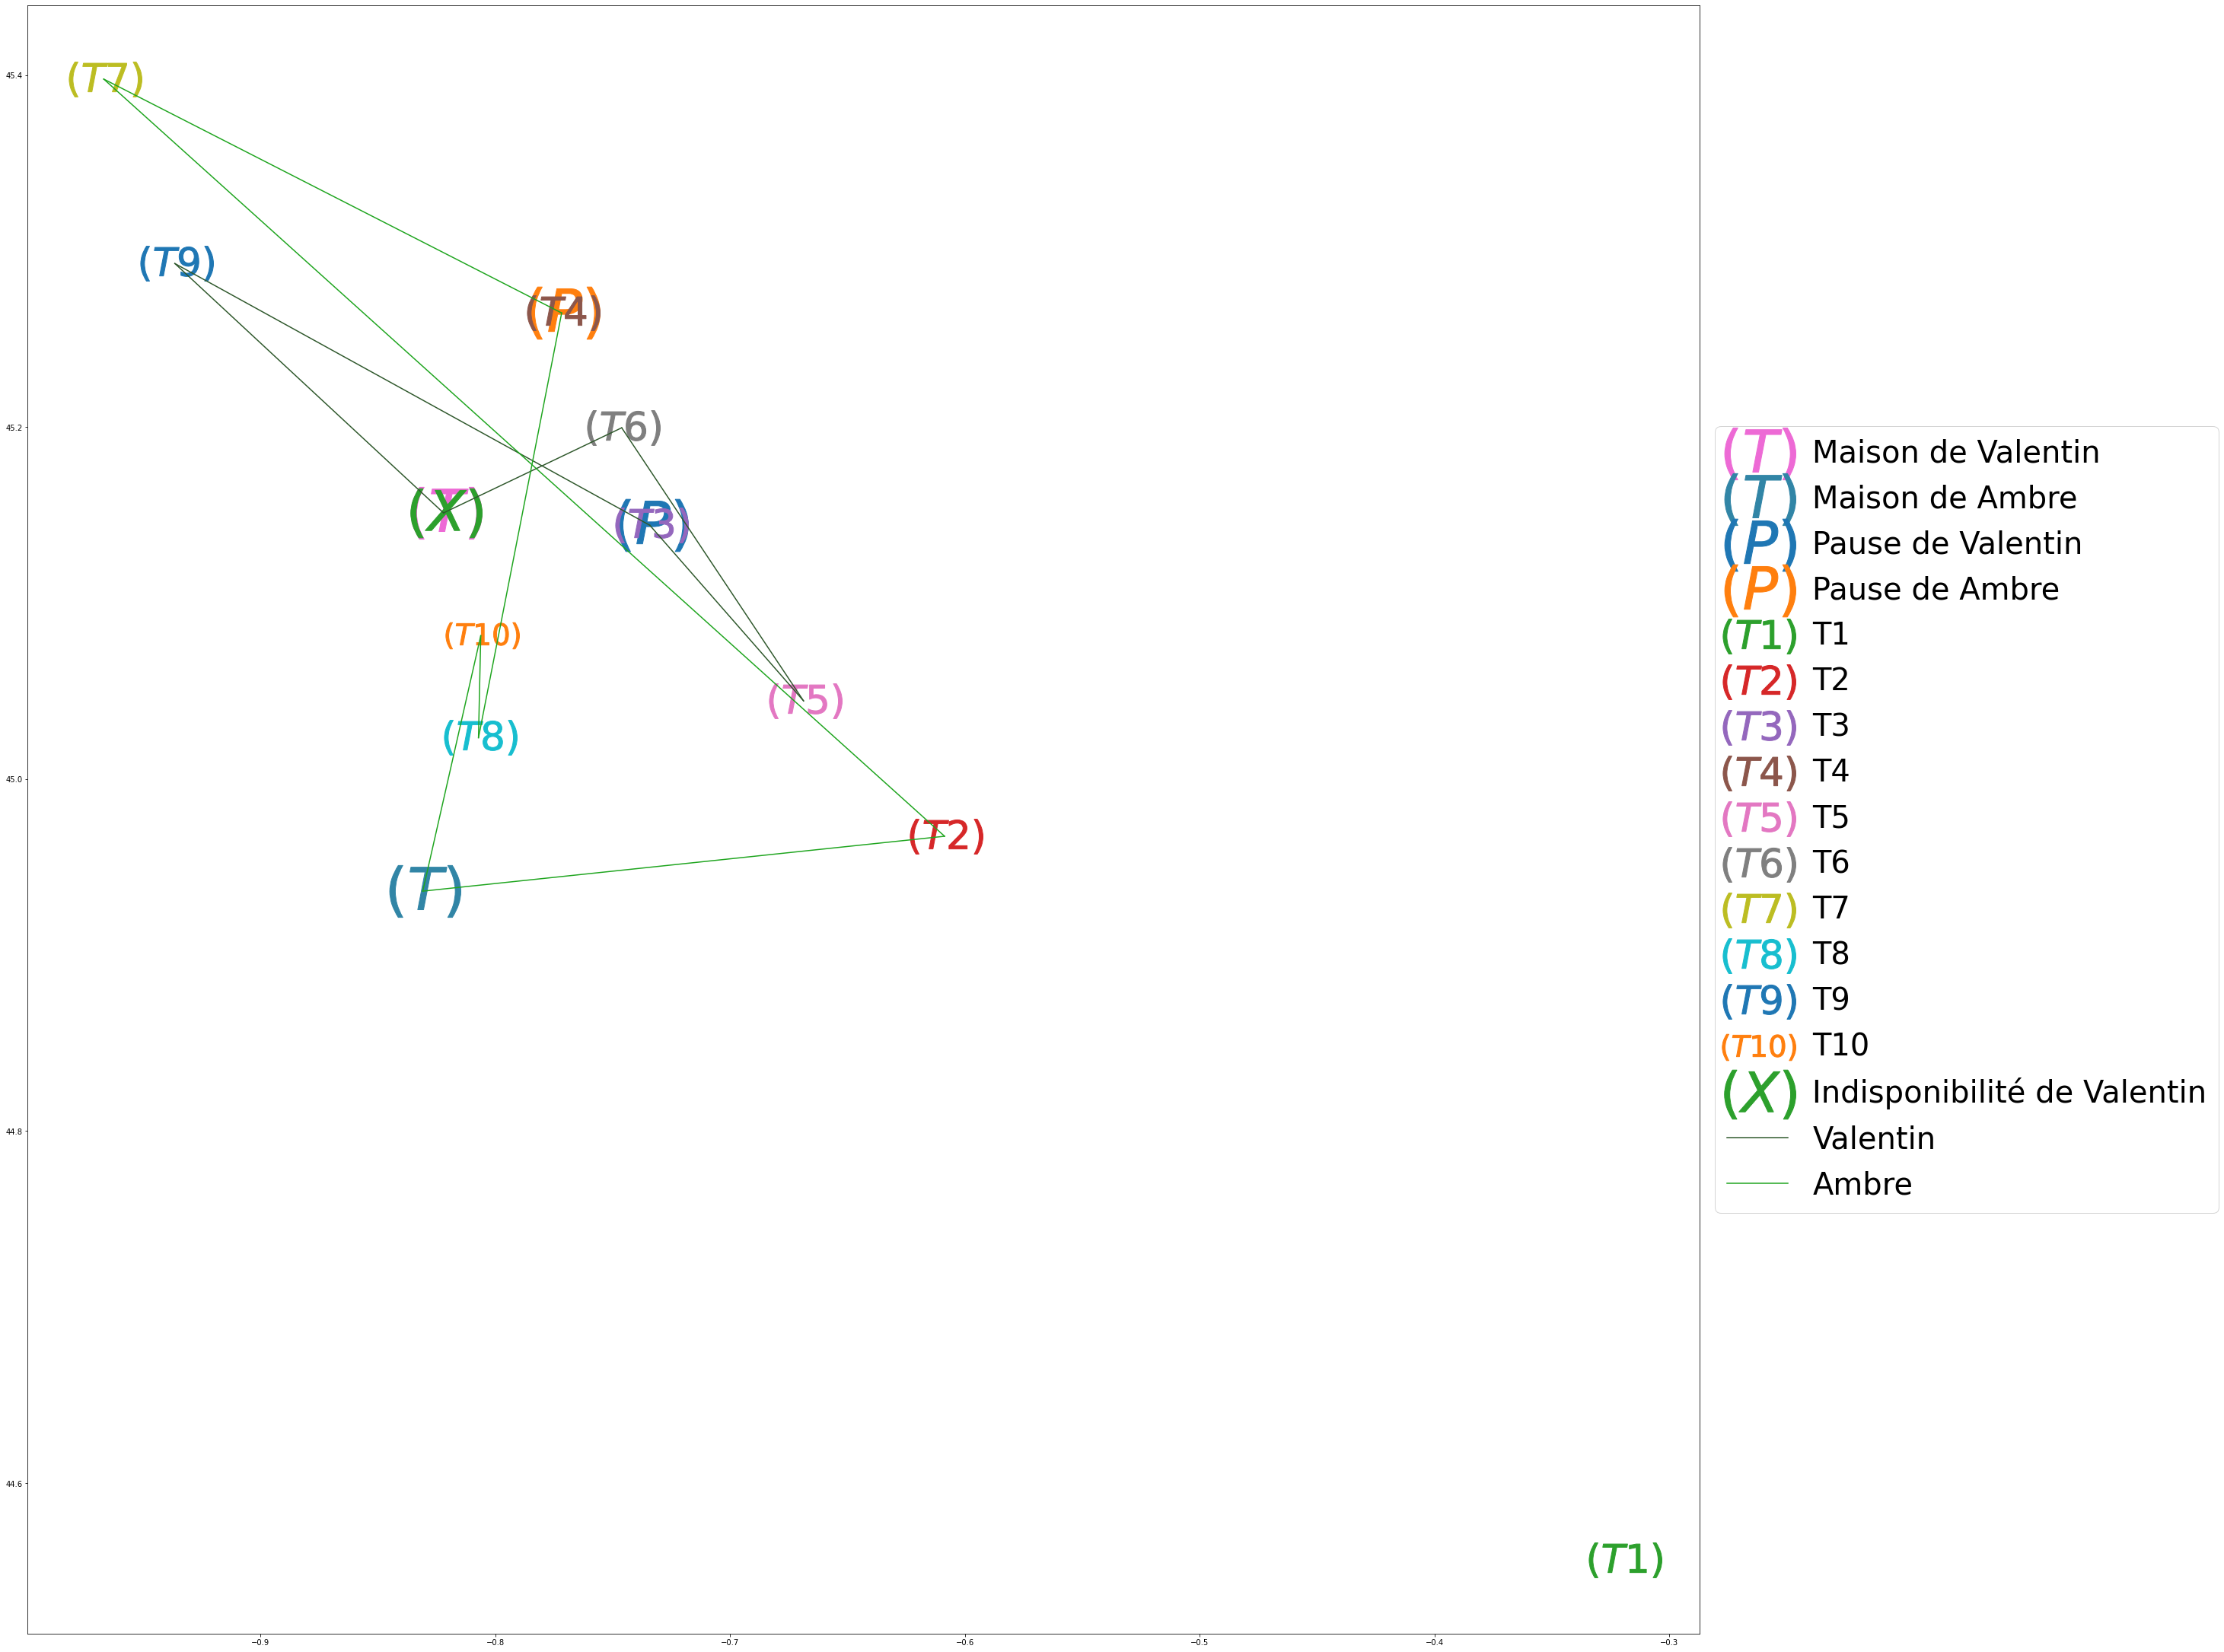

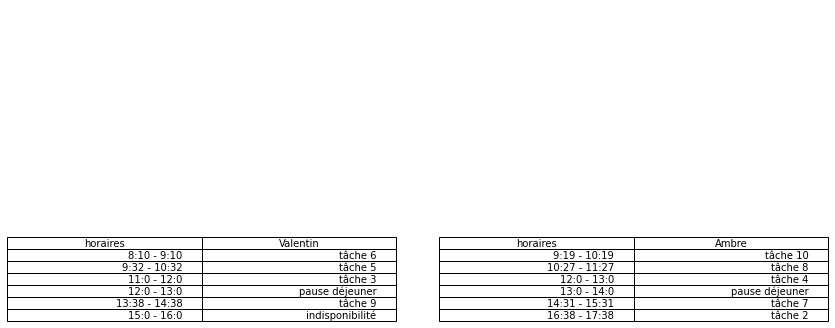

The total distance is 268.5277521892079 km(s).

Itération 2 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 6
1 -> 11
3 -> 1
4 -> 7
5 -> 8
6 -> 4
7 -> 10
8 -> 3
9 -> 5
10 -> 12
11 -> 9
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 1020.0
B[3] = 998.0
B[4] = 576.0
B[5] = 720.0
B[6] = 501.0
B[7] = 676.0
B[8] = 866.0
B[9] = 568.0
B[10] = 818.0
B[11] = 500.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 7 au temps 736.0 
Le technicien 1 effectue sa pause au noeud 5 au temps 780.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


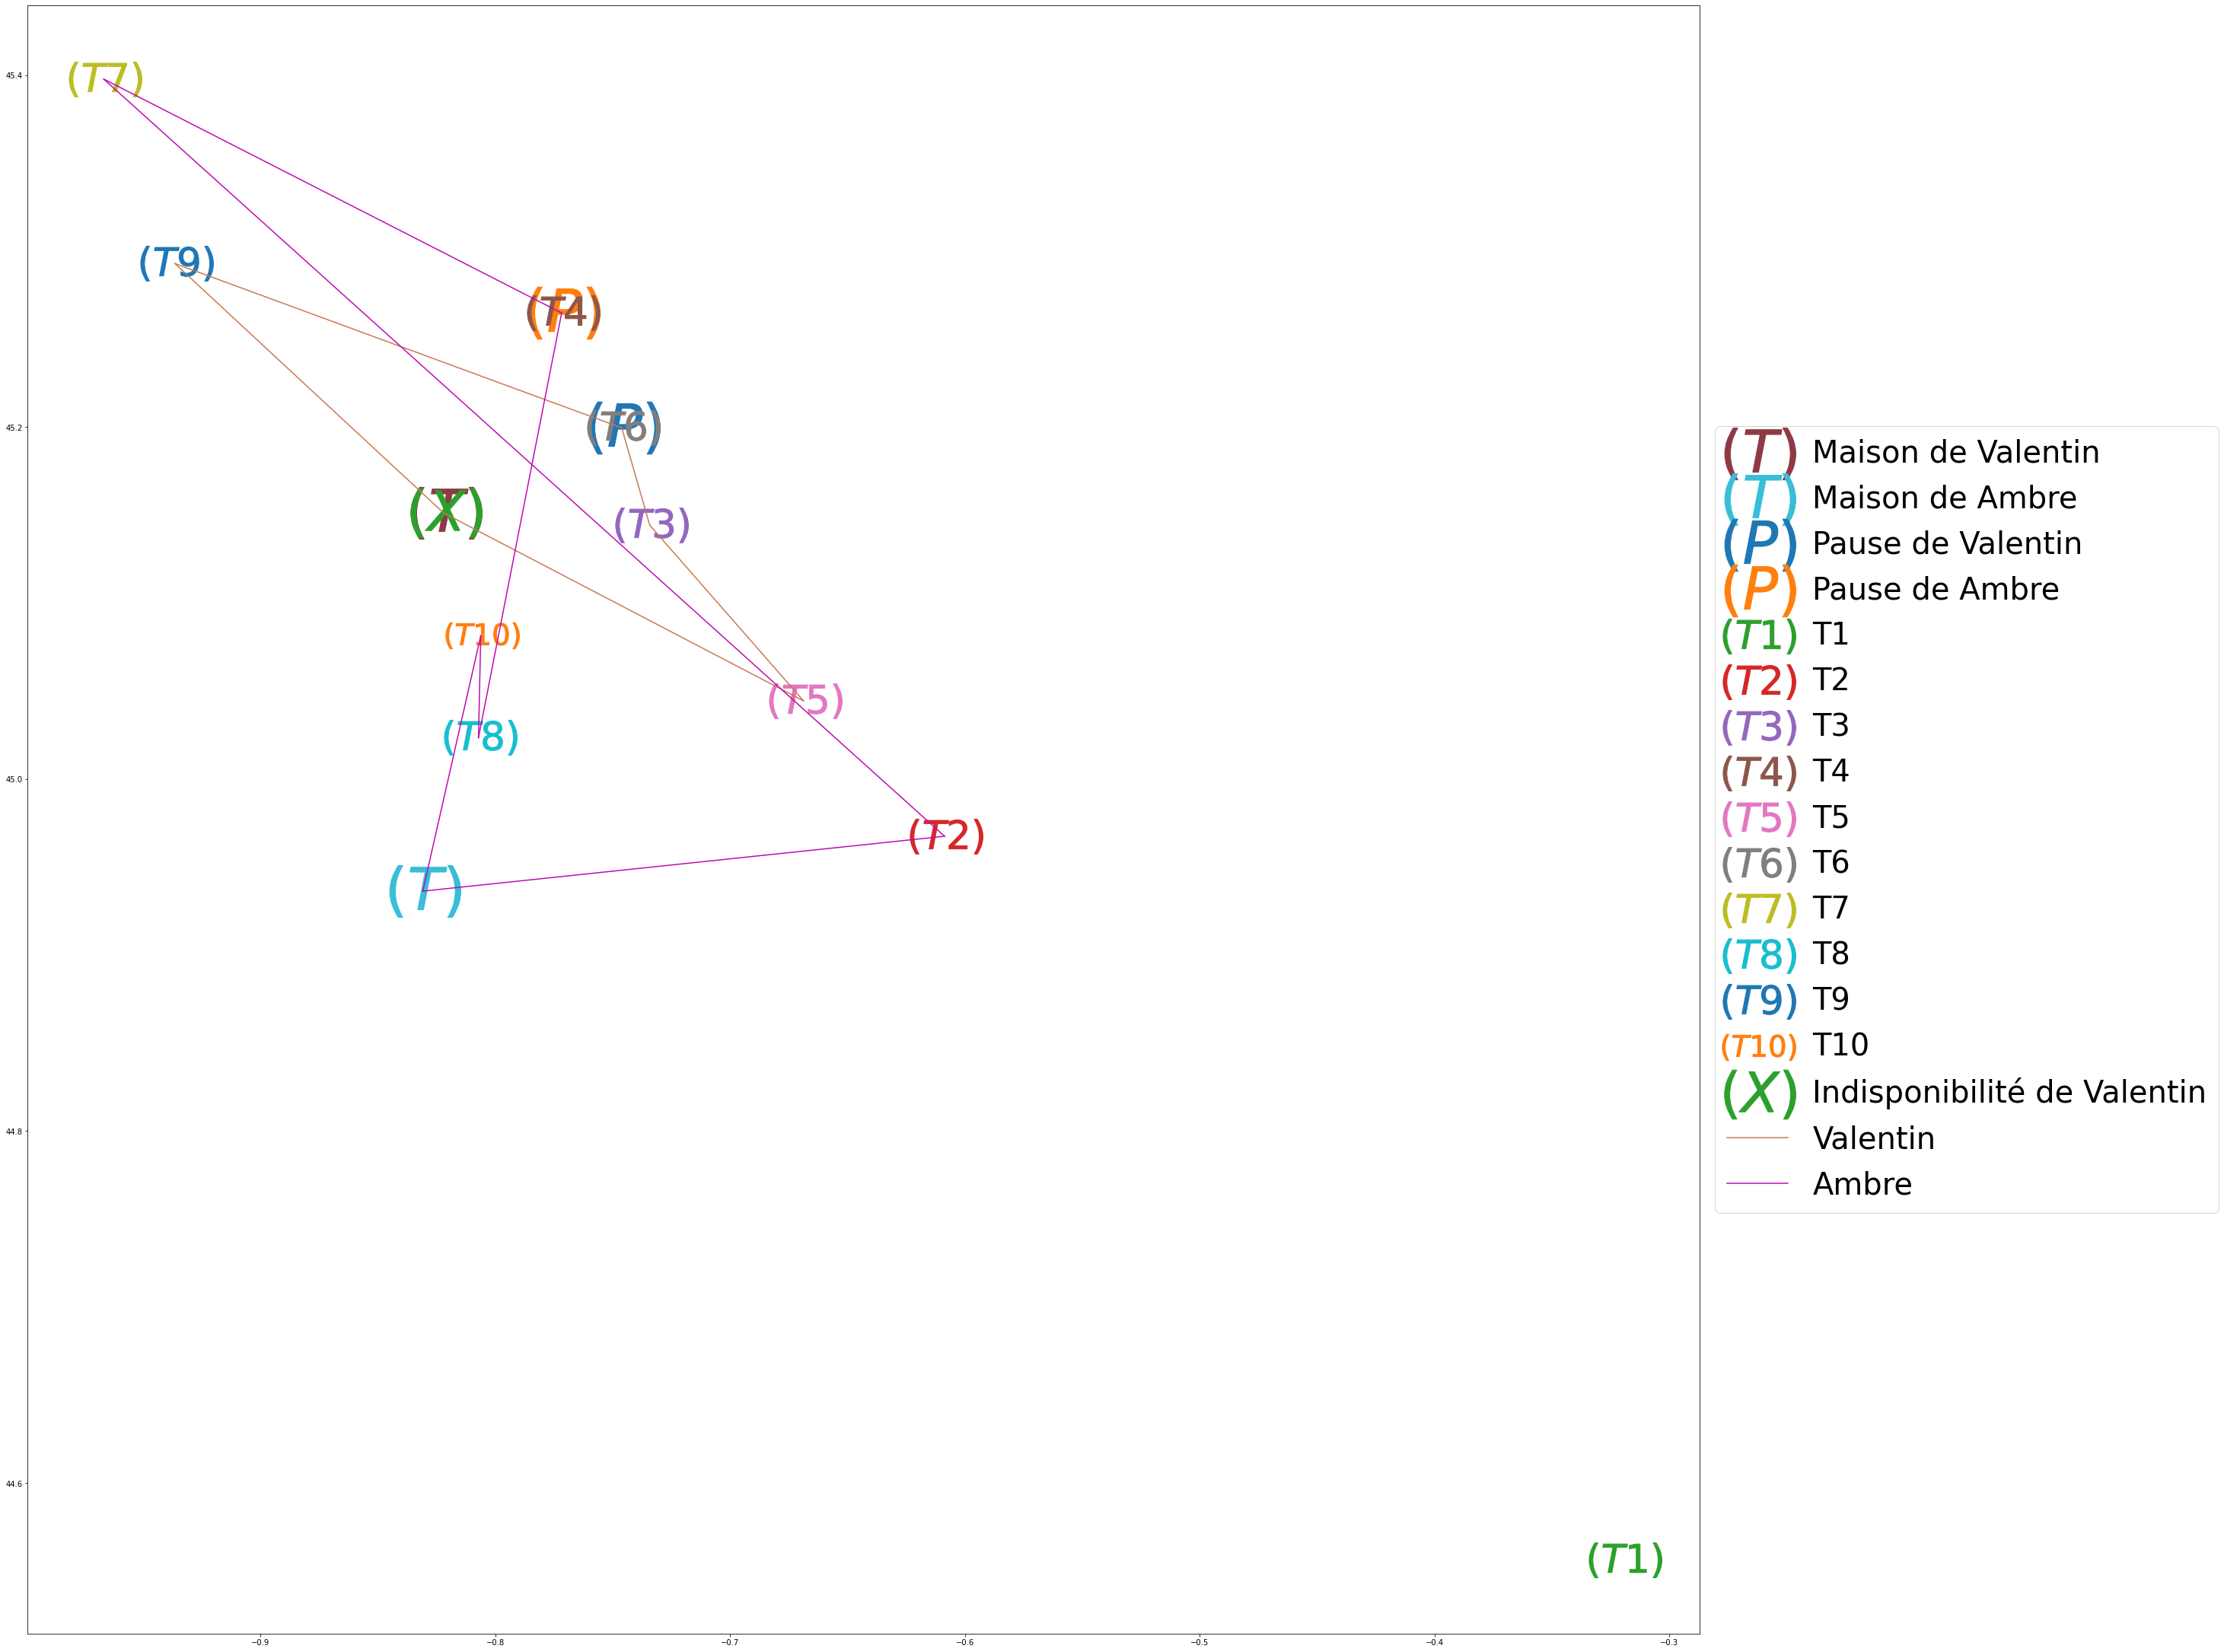

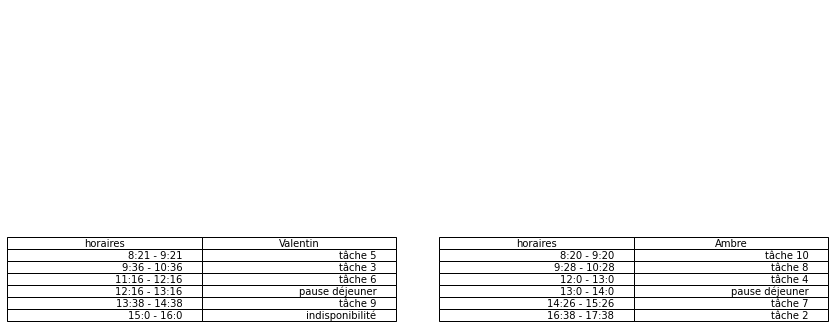

The total distance is 259.0280635528762 km(s).

Itération 3 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 4
1 -> 3
3 -> 9
4 -> 6
5 -> 8
6 -> 7
7 -> 10
8 -> 11
9 -> 5
10 -> 12
11 -> 1
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 480.0
B[3] = 540.0
B[4] = 489.0
B[5] = 714.0
B[6] = 564.0
B[7] = 676.0
B[8] = 895.0
B[9] = 621.0
B[10] = 818.0
B[11] = 1000.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 7 au temps 736.0 
Le technicien 1 effectue sa pause au noeud 5 au temps 774.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


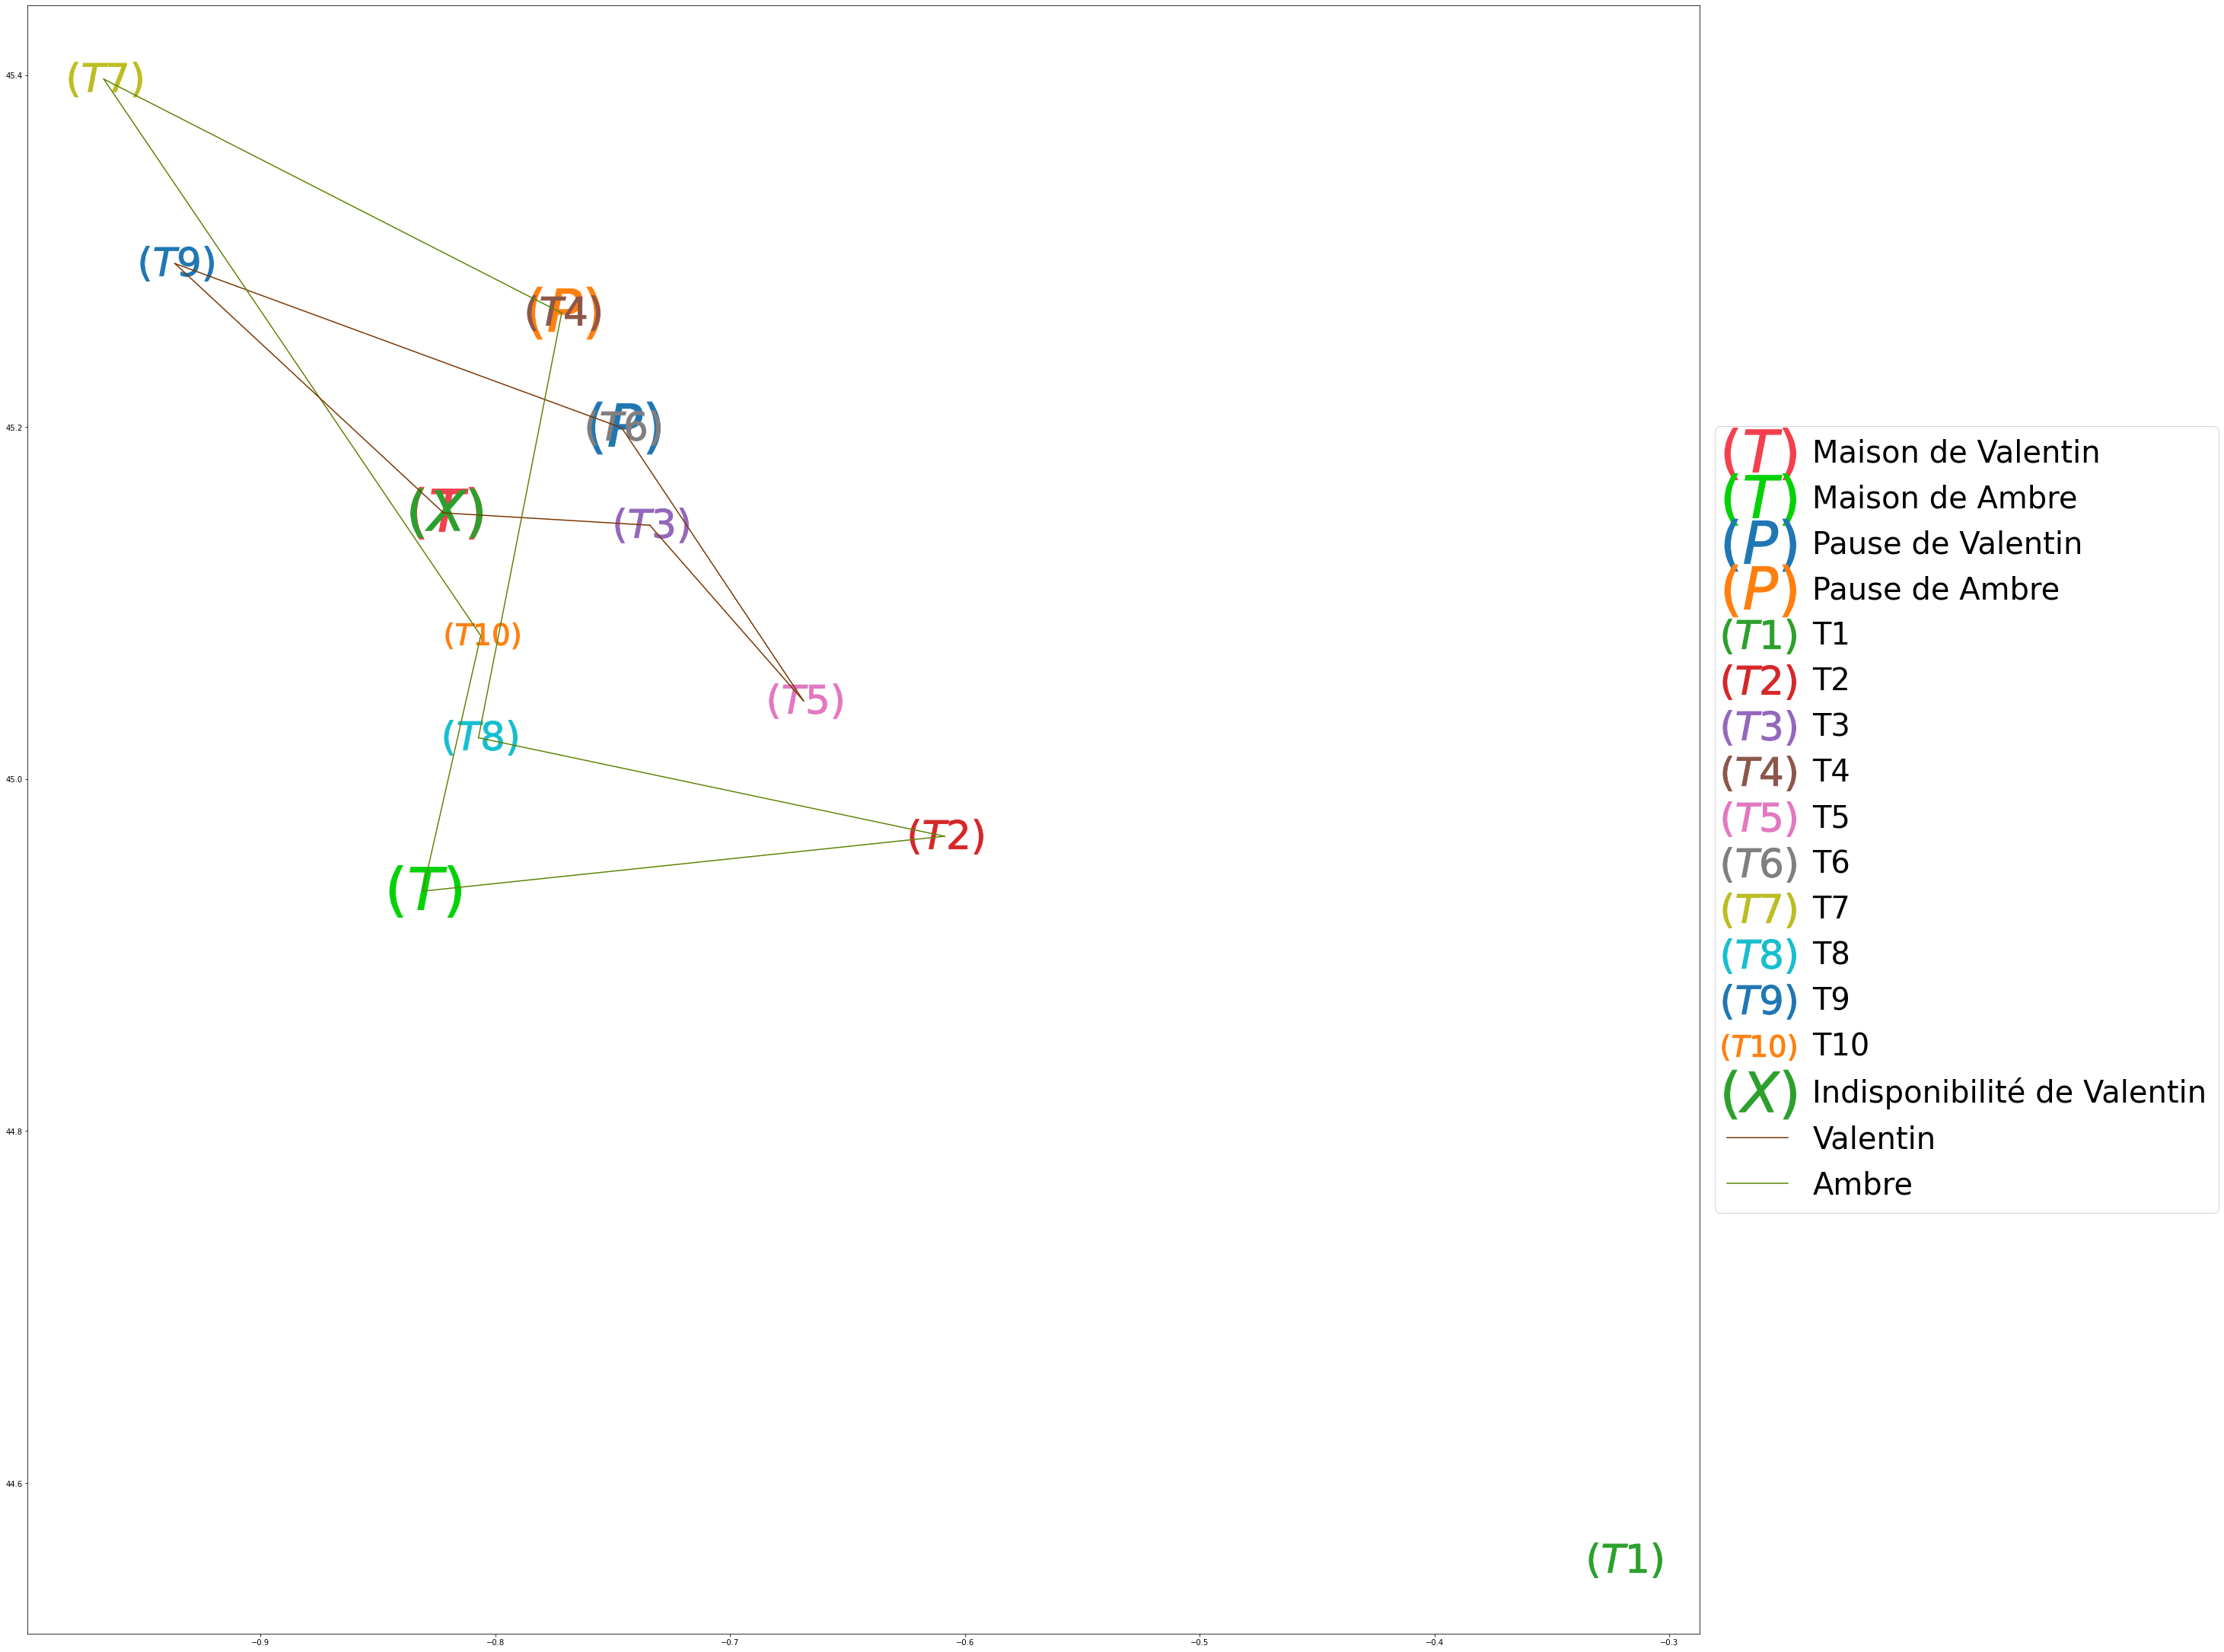

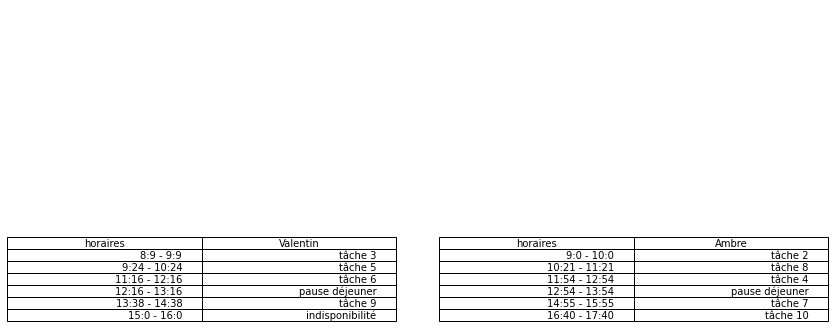

The total distance is 252.22208445647468 km(s).

Itération 4 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 6
1 -> 9
3 -> 1
4 -> 10
5 -> 3
6 -> 4
7 -> 12
8 -> 5
9 -> 11
10 -> 7
11 -> 8
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 480.0
B[3] = 998.0
B[4] = 576.0
B[5] = 895.0
B[6] = 501.0
B[7] = 830.0
B[8] = 720.0
B[9] = 492.0
B[10] = 688.0
B[11] = 560.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 10 au temps 748.0 
Le technicien 1 effectue sa pause au noeud 8 au temps 780.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


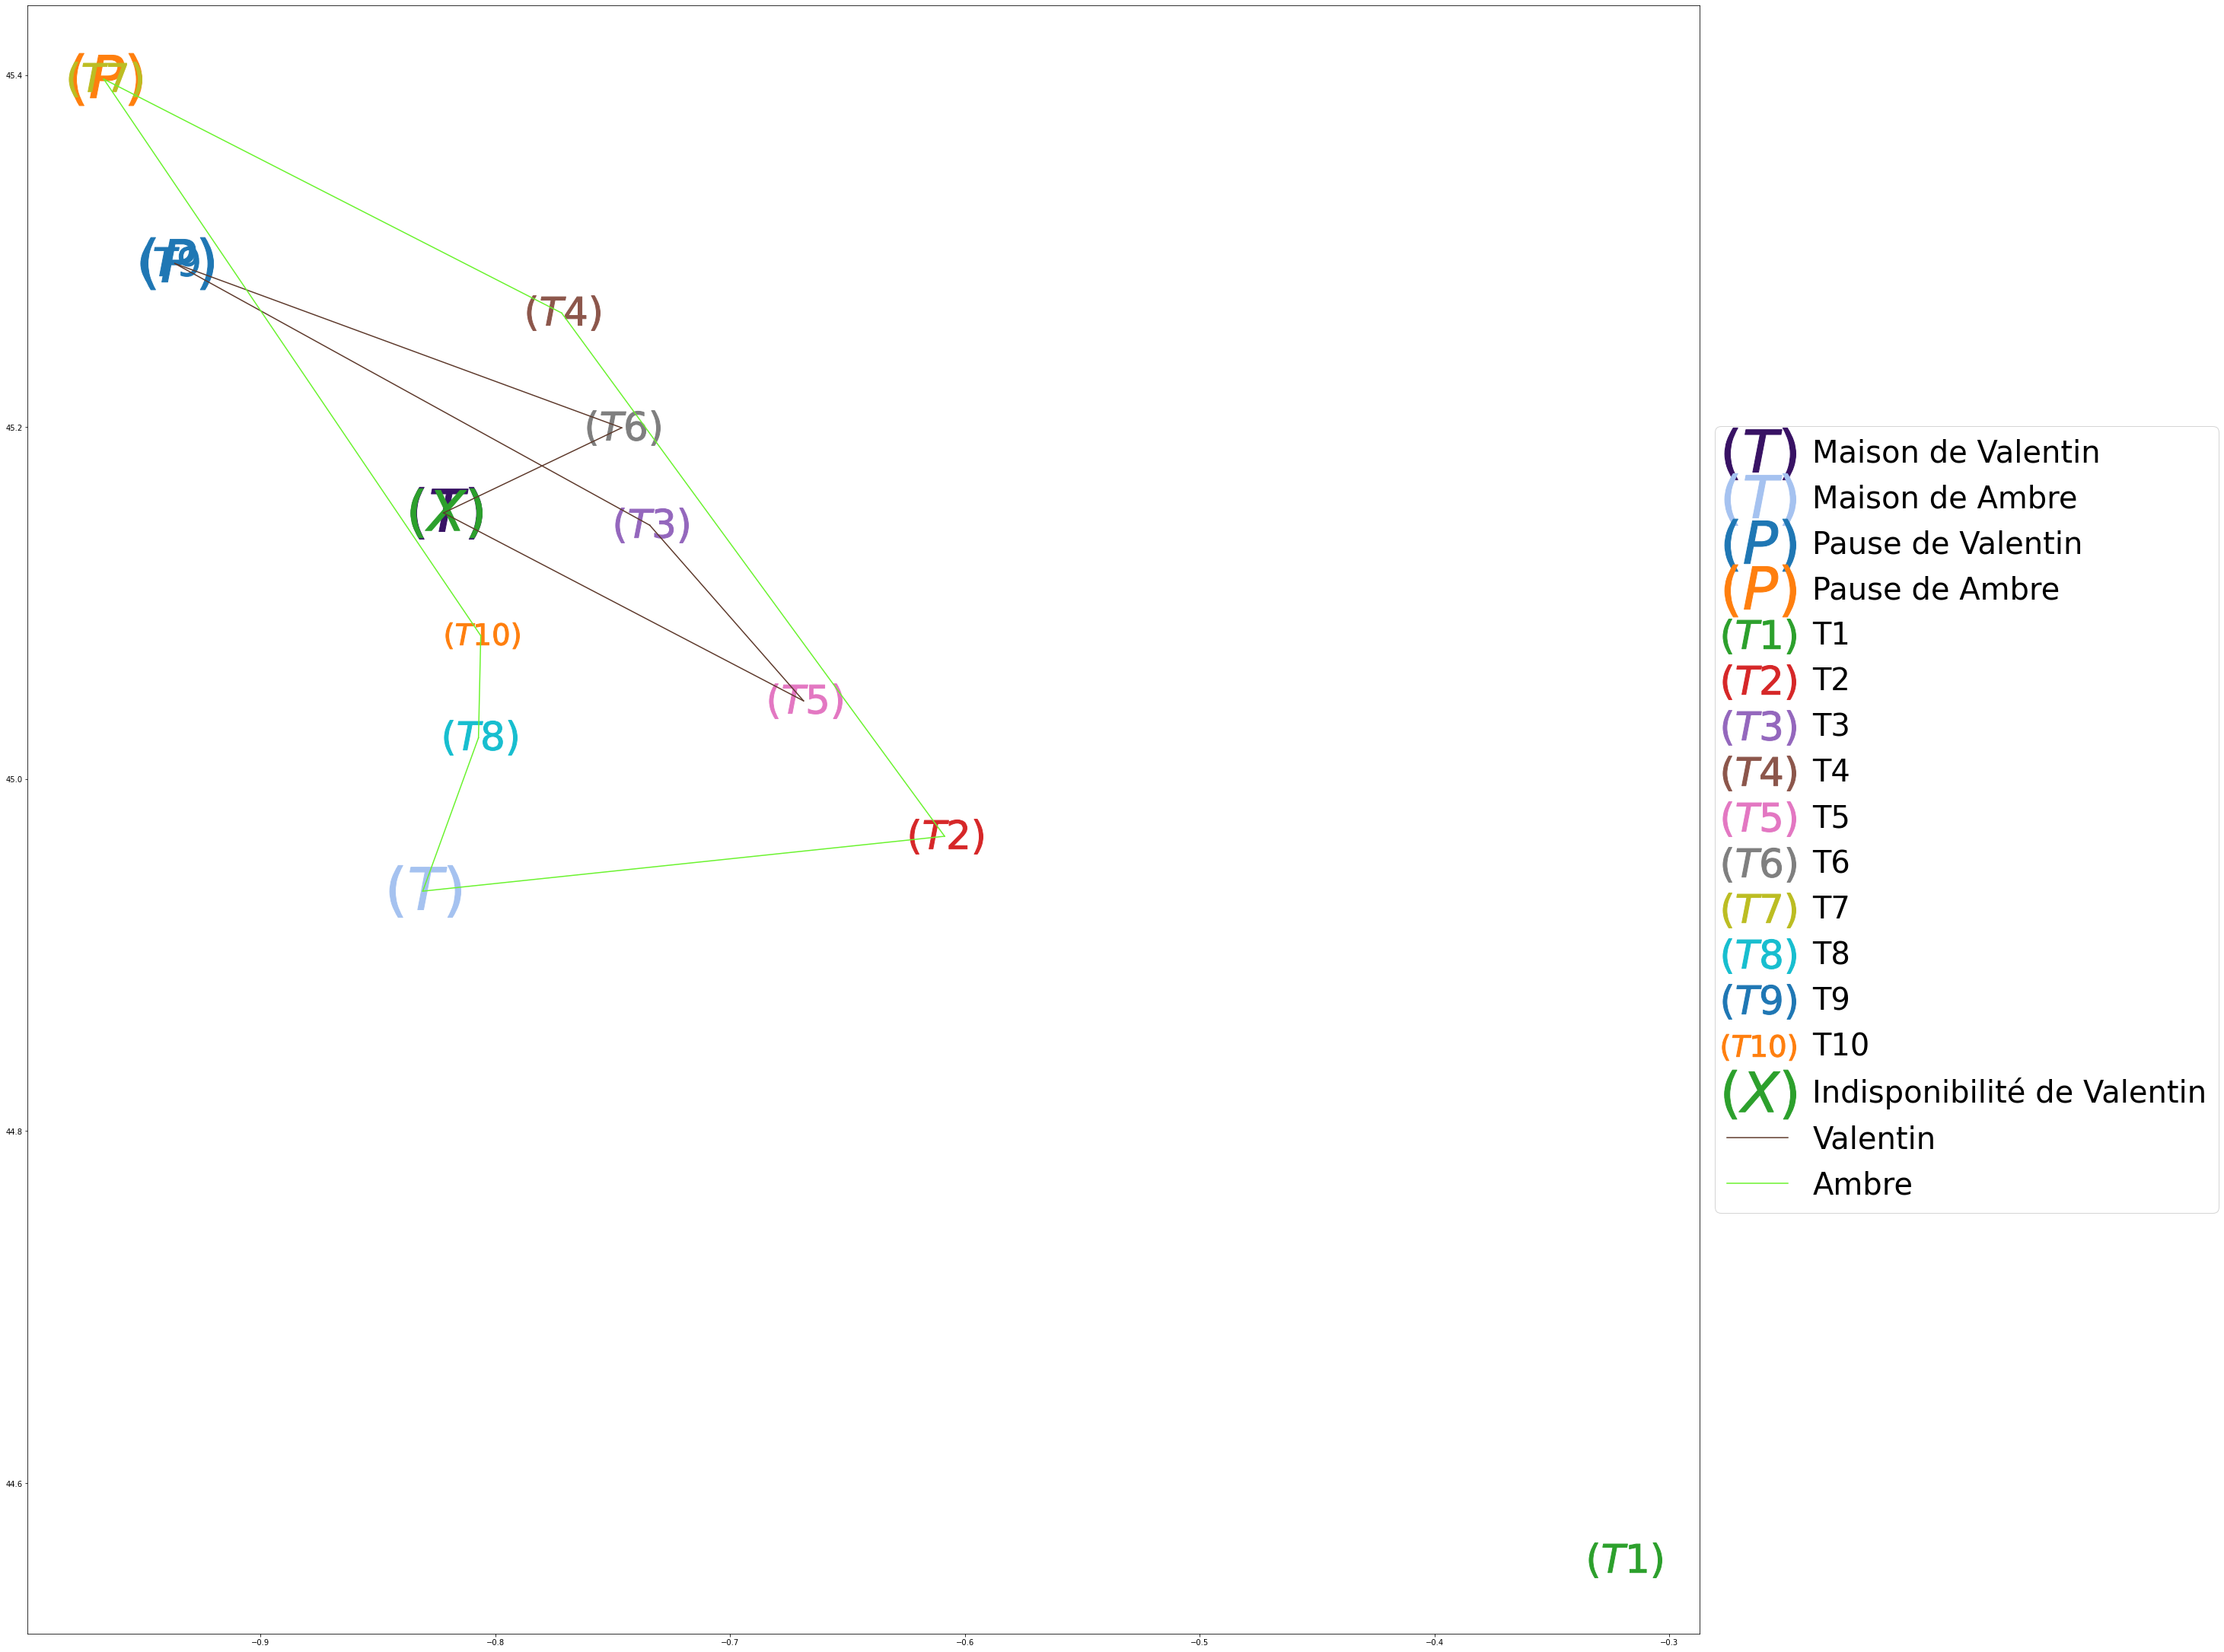

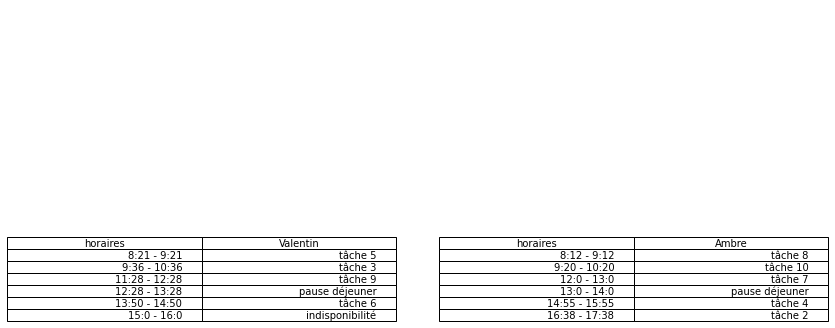

The total distance is 247.66679919472136 km(s).

Itération 5 :

Y[0] : [0, 4, 6, 7, 10, 12]
Y[1] : [1, 3, 5, 8, 9, 11]

0 -> 6
1 -> 3
3 -> 5
4 -> 7
5 -> 8
6 -> 4
7 -> 10
8 -> 11
9 -> 1
10 -> 12
11 -> 9
12 -> 0

B[0] = 480.0
B[1] = 480.0
B[2] = 480.0
B[3] = 540.0
B[4] = 576.0
B[5] = 689.0
B[6] = 501.0
B[7] = 676.0
B[8] = 835.0
B[9] = 1008.0
B[10] = 818.0
B[11] = 940.0
B[12] = 900.0

Le technicien 0 effectue sa pause au noeud 7 au temps 736.0 
Le technicien 1 effectue sa pause au noeud 5 au temps 749.0 
{0: 0, 1: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0}


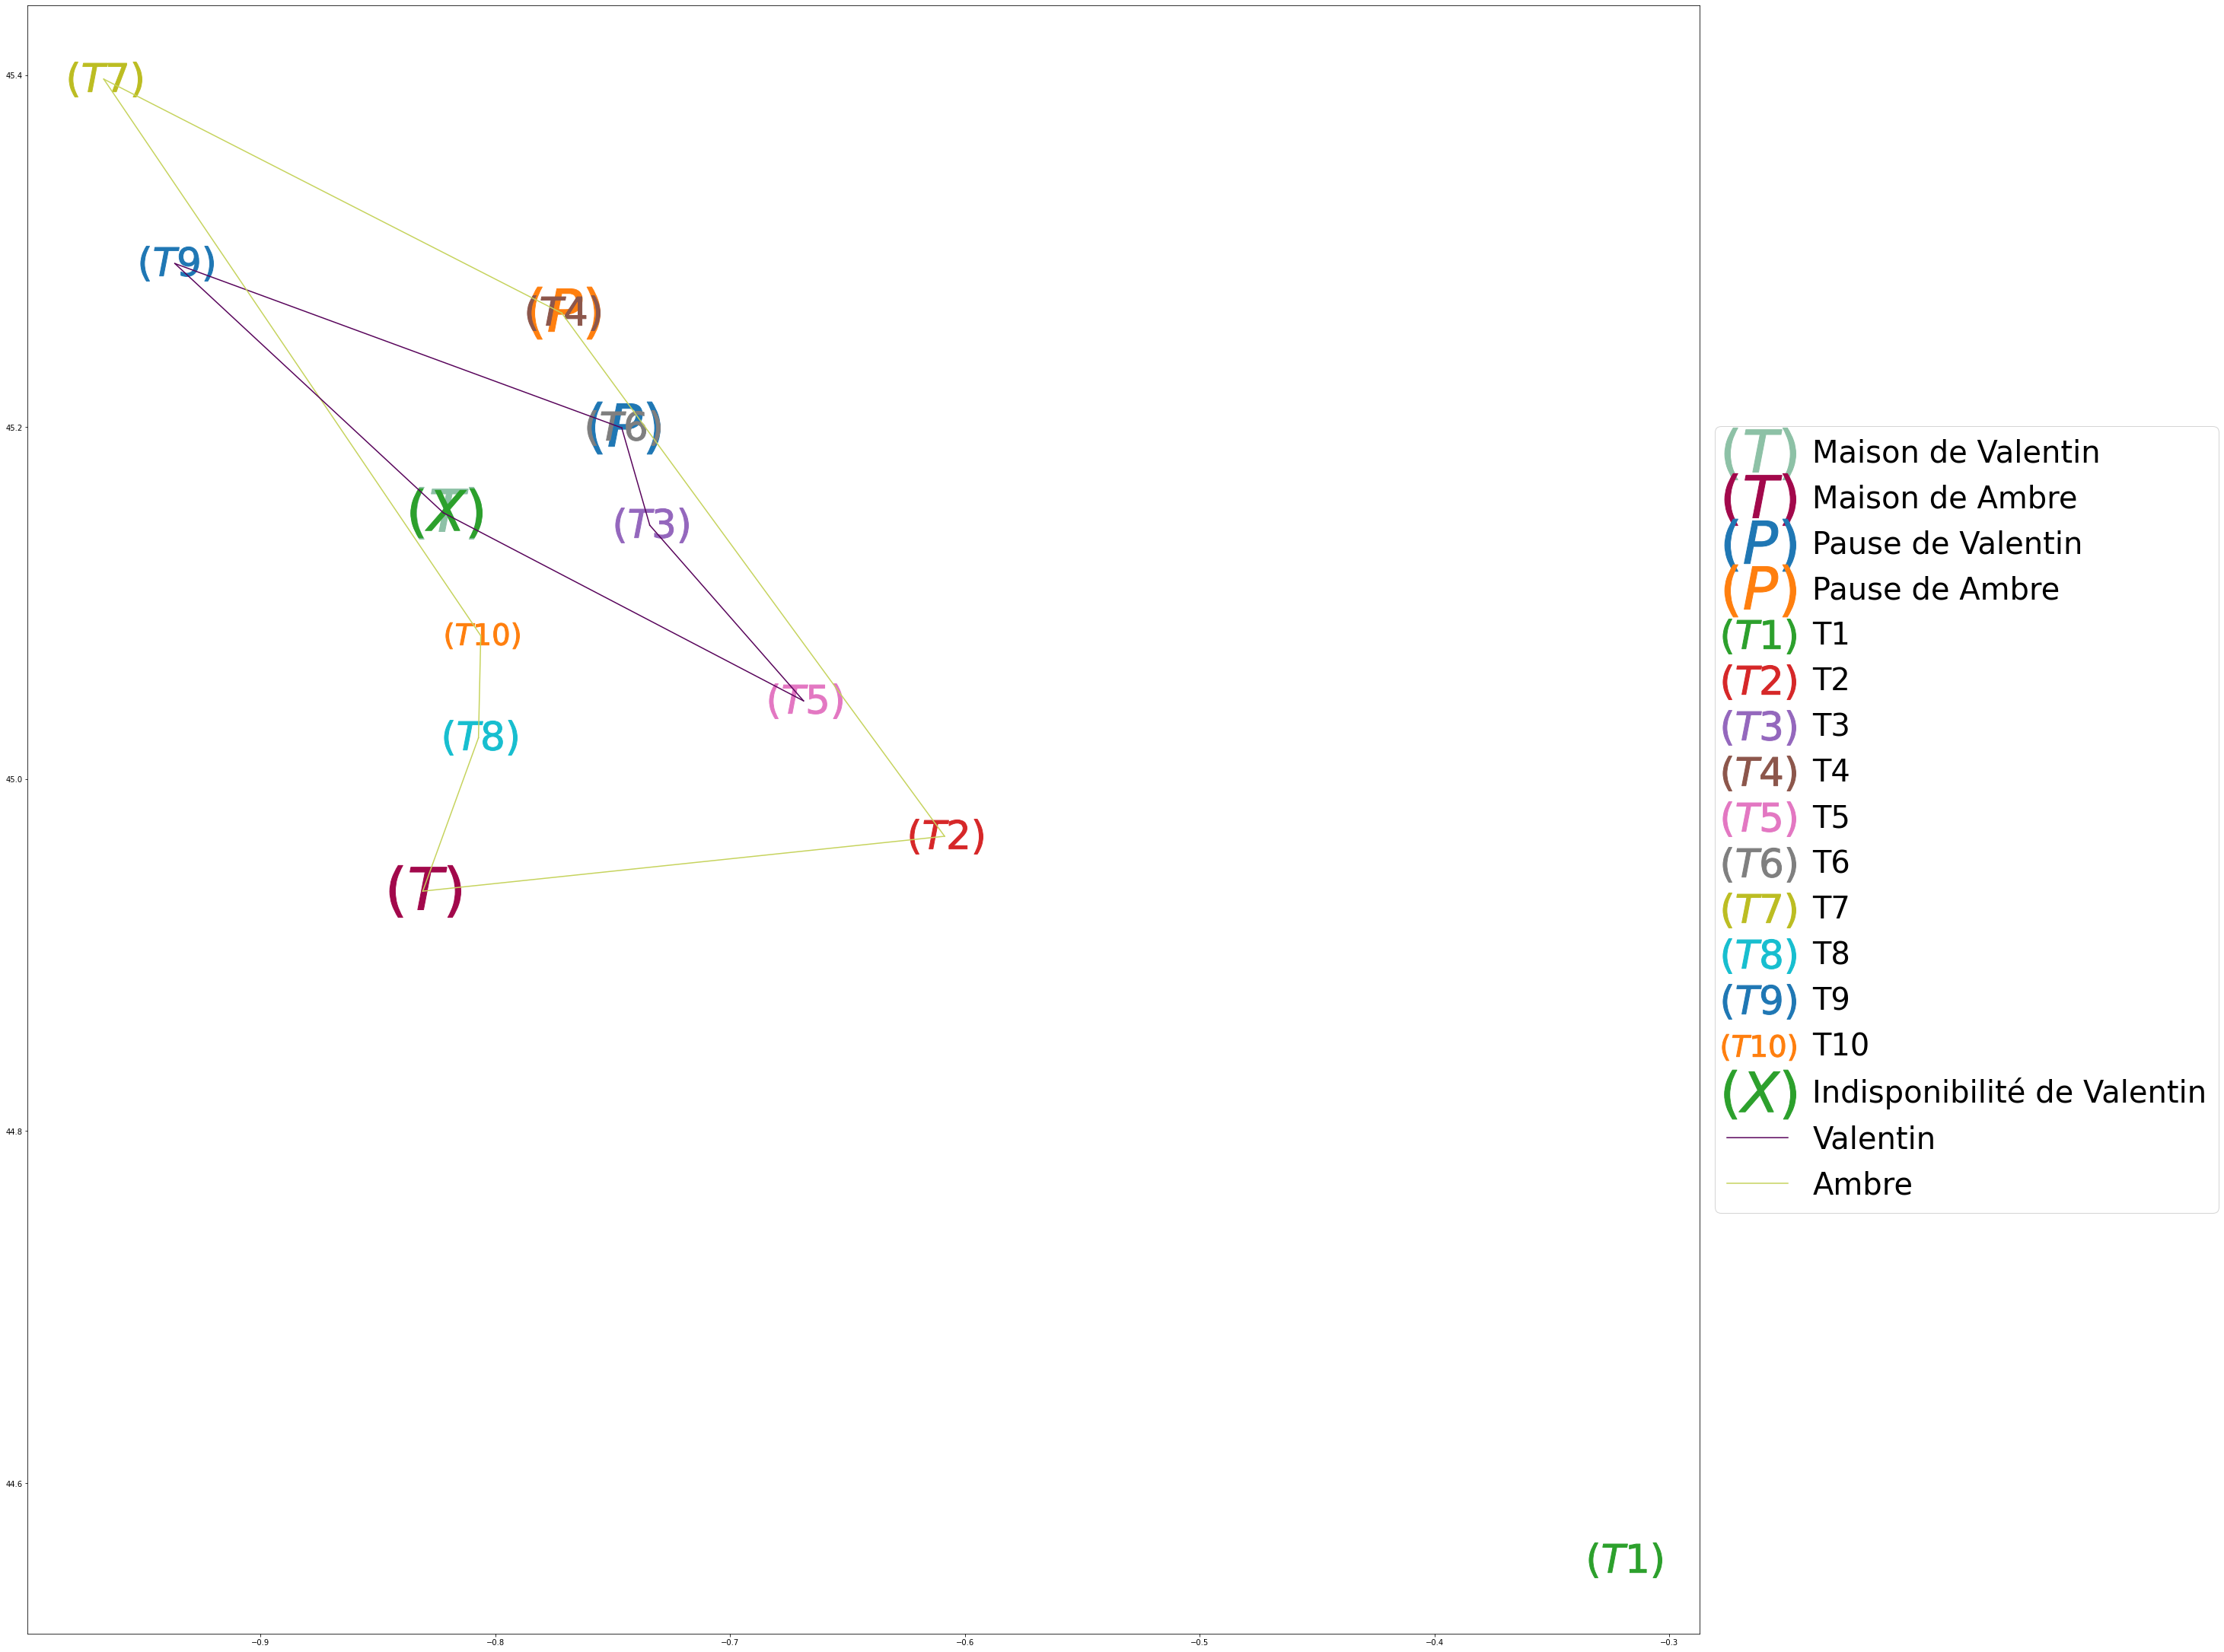

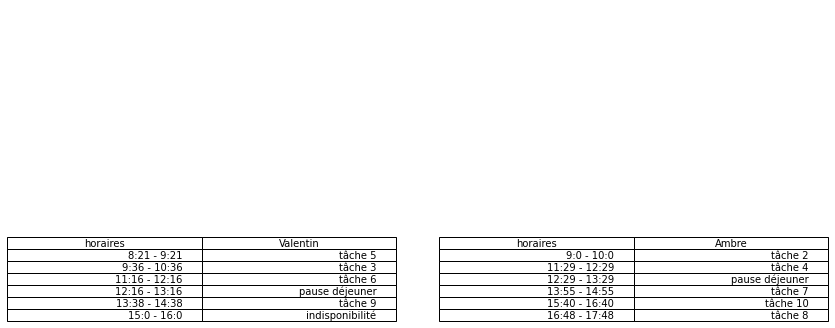

The total distance is 239.7889339998372 km(s).



In [17]:
epsi = 0.01
it = 1

m.params.outputflag = 0

m.update()

m.optimize()

data = []

while m.status != GRB.INFEASIBLE:
    
    print(f"Itération {it} :\n")
    it += 1
    
    for k in employees:
        print("Y[{}] : {}".format(k,[i for i in nodes if Y[(k,i)].x == 1]))
    print()
    for i in nodes:
        for j in nodes:
            if i != j and X[(i,j)].x == 1 :
                print(f"{i} -> {j}")
    print()
    for i in nodes:
        print(f"B[{i}] = {B[i].x}")

    print()

    #lunch_times associe l'heure de début de pause déjeuener pour l'employé k
    lunch_times = {}
    for k in employees:
        for i in nodes:
            if L[(k,i)].x == 1 and i != k :
                lunch_times[k] = B[i].x + Node.list[i].duration
                print(f"Le technicien {k} effectue sa pause au noeud {i} au temps {lunch_times[k]} ")
            elif L[(k,i)].x == 1 and i == k :
                lunch_times[k] = 60*12
                print(f"Le technicien {k} effectue sa pause au noeud {i} au temps {lunch_times[k]} ")
            
    
    # Z associe un indice de tâche à l'employé qui l'effectue
    Z = {}
    for i in nodes:
        for k in employees:
            if Y[(k,i)].x == 1:
                Z[i] = k
    print(Z)
    
    plot_map(Employee.list, Node.list, tasks, unavails, X, L, Z)
    plot_agenda(Employee.list, Node.list, tasks, unavails, B, Z,lunch_times)
    store_result(path_result,Employee.list,tasks,lunch_times,Z,B)
    
    total_dist = quicksum([Node.distance[i,j]*X[(i,j)] for i in nodes for j in nodes if i != j])/Employee.speed
    print(f"The total distance is {total_dist.getValue()} km(s).\n")
    
    data.append((total_dist.getValue(), obj.getValue()))
    
    #----------#
    
    m.addConstr(total_dist <= total_dist.getValue() - epsi)
    
    m.update()

    m.optimize()

#### Affichons les solutions non-dominées obtenues

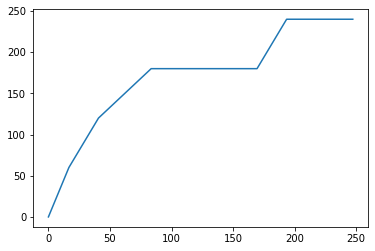

In [ ]:
x = np.array([dist for dist, _ in data])
y = np.array([duration for _, duration in data])

plt.plot(x, y)
plt.show()

In [ ]:
print(data)

[(247.24777041342858, 240.0), (193.49706393768187, 240.0), (169.46480997932372, 180.0), (83.46281005248306, 180.0), (40.66967435968034, 120.0), (16.637420401322217, 60.0), (0.0, 0.0)]
